In [2]:
import numpy as np
import pandas as pd
import sklearn 
import costcla
import itertools
import scipy.stats as ss
from imblearn.over_sampling import RandomOverSampler
import pydot
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from functools import partialmethod
pd.DataFrame.head = partialmethod(pd.DataFrame.head, n=5)

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)

## Introduction

#### Objective

The objective of this work is to create a model to classify unemployed/employed persons based on several social characteristics. 

#### Data Source

Data is sourced from the Irish National Household Survey (year=2015), available from www.ISDA.ie. 

The data contains information on the respondents' labour status (are they unemployed/working/studying etc), and a range of variables about their educational and demographic background (such as education level, education field, age, marital status, region of residency etc). 

#### Description of variables:

mainstatus: 1=employed, 2=unemployed, 3=student, 4=not in labour force

sex: 1=male, 2=female 

marriage status: 1=single, 2=married, 3=widowed, 4=divorced

nationality: 1= ireland, 2=uk, 3=eu15, 4=rest of eu, 5=usa/canada, 5=rest of world

    nationality_1: almost the same
    
    nationality_3: almost the same 
    
education level: 
000=no formal education, 
100=ISCED1, 
200=ISCED2, 
300=ISCED3, 303=ISCED 3, 304=ISCED3, 
400=ISCED4, 
500=ISCED5, 
600=ISCED6, 
700=SCIED7, 
800=ISCED8, 
999=Not applicable. (where ISCED1-3~Primary school, ISCED4-5~Secondary School and ISCED6-8~Tertiary level)

education field: 
000= General programmes Data available from Q1 2004 to Q4 2013
100= Teacher training and education science
200= Humanities, languages and arts
222= Foreign languages
300= Social sciences, business and law
400= Science, mathematics and computing (no distinction possible)
420= Life science (including Biology and Environmental science)
440= Physical science (including Physics, Chemistry and Earth
science)
460= Mathematics and statistics
481= Computer science
482= Computer use
500= Engineering, manufacturing and construction
600= Agriculture and veterinary
700= Health and welfare
800= Services
900= Unknown
999= Not applicable (HATLEVEL= 00,11,21,99, Blank)
Blank No answer


age_group:
01= Aged 0 to 4 years
02= Aged 5 to 9 years
03= Aged 10 to 14 years
04= Aged 15 to 19 years
05= Aged 20 to 24 years
06= Aged 25 to 29 years
07= Aged 30 to 34 years
08= Aged 35 to 39 years
09= Aged 40 to 44 years
10= Aged 45 to 49 years
11= Aged 50 to 54 years
12= Aged 55 to 59 years
13= Aged 60 to 64 years
14= Aged 65 to 69 years
15= Aged 70 to 74 years
16= Aged 75 to 79 years
17= Aged 80 to 84 years
18= Aged 85 or more

household_type:
1= Couple family unit – no children
2= Couple family unit – with children
3= Lone parent family unit
9= Not applicable (FAMILYUNITGROUPNUMBER=0)

region: 
01= Border, Midland and Western 
    011=Border 
    012=Midland 
    013=Western
02= Southern and Eastern 
    021=Dublin 
    022=Mid-East 
    023=Mid-West 
    024=South-East 
    025South-West


### Load data

In [3]:
path_to_file = r"C:\Users\mnacheva\Desktop\desktop\ML\Project\QNHS_2015.csv"
df=pd.read_csv(path_to_file)

In [4]:
#rename variables
df.rename(columns={"mainstat":"status", 
                   "marstat":"marriage_status",
                   "national_summary_x1":"nationality_1",
                   "national_summary_x3": "nationality_3",
                   "national_summary":"nationality", 
                   "hatlevel":"education_level", 
                   "hatfield":"education_field", 
                   "ageclass":"age_group", 
                   "familytypesummary":"household_type"}, inplace=True)



In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95986 entries, 0 to 95985
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   status              95941 non-null  float64
 1   sex                 95986 non-null  int64  
 2   marriage_status     95986 non-null  int64  
 3   nationality_1       0 non-null      float64
 4   nationality_3       95981 non-null  float64
 5   nationality         95985 non-null  float64
 6   education_level     93995 non-null  float64
 7   education_field     93816 non-null  float64
 8   age_group           95986 non-null  int64  
 9   familytype_summary  95986 non-null  int64  
 10  region              95986 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 8.1 MB


In [6]:
df.drop(columns=["nationality_1", "nationality_3"], inplace=True)


### Clean Data

In [7]:
#Target column 'status' contains several classes. Filter out those except unemployed and employed. 
#Set labels as employed=0, unemployed=1.

mask=np.array((df.status==2) | (df.status==1))
df=df[mask]
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)

df["status"].replace(to_replace=1,value=0, inplace=True)
df["status"].replace(to_replace=2,value=1, inplace=True)

In [8]:
#Check for NAN
df.isna().sum()


status                   0
sex                      0
marriage_status          0
nationality              0
education_level       1336
education_field       1674
age_group                0
familytype_summary       0
region                   0
dtype: int64

In [9]:
# fill NAN with mode values 
for c in df.columns:
    df[c].fillna(int(df[c].mode()), inplace=True)
df.isna().sum()


status                0
sex                   0
marriage_status       0
nationality           0
education_level       0
education_field       0
age_group             0
familytype_summary    0
region                0
dtype: int64

### Summarise Data

In [10]:
df.head()

,status,sex,marriage_status,nationality,education_level,education_field,age_group,familytype_summary,region
0,0.0,1,2,1.0,600.0,0.0,11,2,1
1,0.0,1,1,1.0,100.0,9999.0,13,9,1
2,0.0,1,1,1.0,100.0,9999.0,14,9,1
3,0.0,1,2,1.0,304.0,0.0,13,1,2
4,0.0,2,1,1.0,304.0,0.0,7,3,2


In [11]:
#Print unique values for each feature
for column in df: 
    print("unique values:")
    print(column, list(pd.Series(df[column]).drop_duplicates()))
    

unique values:
status [0.0, 1.0]
unique values:
sex [1, 2]
unique values:
marriage_status [2, 1, 4, 3]
unique values:
nationality [1.0, 3.0, 4.0, 6.0, 2.0, 5.0]
unique values:
education_level [600.0, 100.0, 304.0, 200.0, 700.0, 400.0, 500.0, 300.0, 0.0, 800.0, 303.0]
unique values:
education_field [0.0, 9999.0, 300.0, 500.0, 600.0, 800.0, 100.0, 420.0, 700.0, 222.0, 200.0, 460.0, 900.0, 482.0, 481.0, 440.0]
unique values:
age_group [11, 13, 14, 7, 6, 10, 12, 15, 8, 9, 5, 4, 16, 17, 18]
unique values:
familytype_summary [2, 9, 1, 3]
unique values:
region [1, 2]


In [12]:
#Print occurance of unique values for each column
df_unique=df.apply(pd.Series.value_counts, normalize=True)
with pd.option_context("display.max_rows",100):display(df_unique)
df_unique

#Note: Data is imbalanced 

,status,sex,marriage_status,nationality,education_level,education_field,age_group,familytype_summary,region
0.0,0.891633,NaN,NaN,NaN,0.001523,0.283462,NaN,NaN,NaN
1.0,0.108367,0.551391,0.372856,0.881731,NaN,NaN,NaN,0.183566,0.246878
2.0,NaN,0.448609,0.565493,0.017842,NaN,NaN,NaN,0.564732,0.753122
3.0,NaN,NaN,0.014611,0.016157,NaN,NaN,NaN,0.099573,NaN
4.0,NaN,NaN,0.047040,0.060358,NaN,NaN,0.012141,NaN,NaN
5.0,NaN,NaN,NaN,0.001754,NaN,NaN,0.065020,NaN,NaN
6.0,NaN,NaN,NaN,0.022158,NaN,NaN,0.095049,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.125516,NaN,NaN
8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.136780,NaN,NaN
9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.136896,0.152129,NaN


,status,sex,marriage_status,nationality,education_level,education_field,age_group,familytype_summary,region
0.0,0.891633,NaN,NaN,NaN,0.001523,0.283462,NaN,NaN,NaN
1.0,0.108367,0.551391,0.372856,0.881731,NaN,NaN,NaN,0.183566,0.246878
2.0,NaN,0.448609,0.565493,0.017842,NaN,NaN,NaN,0.564732,0.753122
3.0,NaN,NaN,0.014611,0.016157,NaN,NaN,NaN,0.099573,NaN
4.0,NaN,NaN,0.047040,0.060358,NaN,NaN,0.012141,NaN,NaN
...,...,...,...,...,...,...,...,...,...
600.0,NaN,NaN,NaN,NaN,0.217819,0.020681,NaN,NaN,NaN
700.0,NaN,NaN,NaN,NaN,0.078961,0.075961,NaN,NaN,NaN
800.0,NaN,NaN,NaN,NaN,0.009417,0.044455,NaN,NaN,NaN
900.0,NaN,NaN,NaN,NaN,NaN,0.007040,NaN,NaN,NaN


### Visualize Data with Seaborn

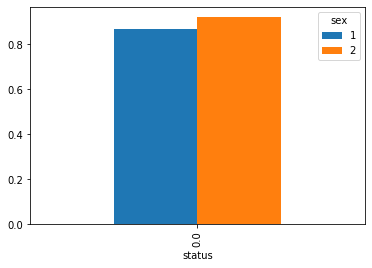

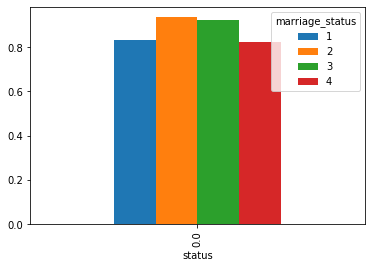

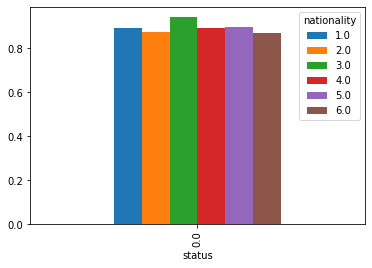

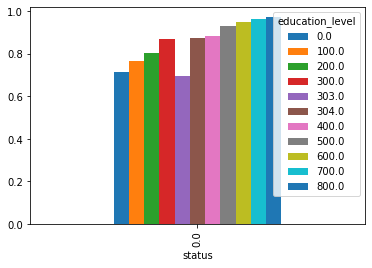

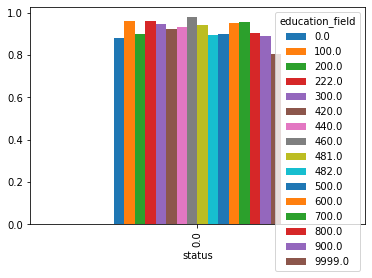

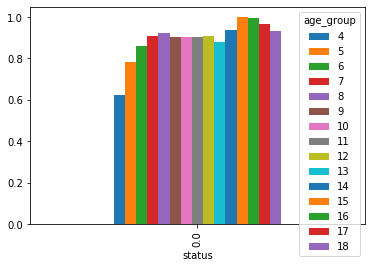

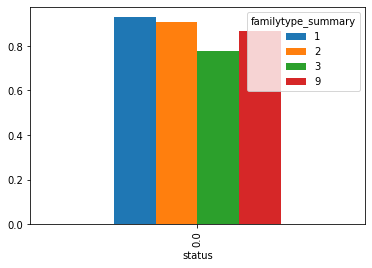

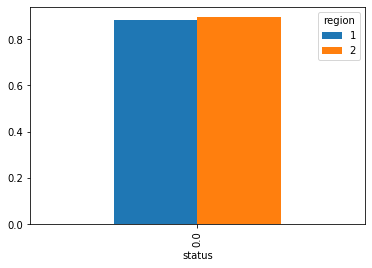

In [13]:
dict_crosstabs=dict()
for column in list(df.columns[1:len(df.columns)]): 
    dict_crosstabs[column]=pd.DataFrame(pd.crosstab(df.status, df[column], normalize='columns').iloc[0:1,:])
    dict_crosstabs[column].plot.bar()
    plt.show()

### Cross-Crorrelations 


In [14]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


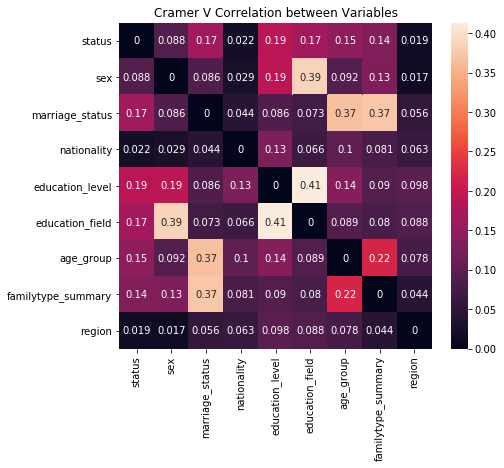

In [15]:
cols = list(df.columns)
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");



### Decision Tree Classificiation

##### Select Features & Train/Test Split


In [16]:
X = df[['marriage_status', "education_level", "education_field", "age_group", "familytype_summary"]]
y = df['status']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=49)
#print(f'X_train: {X_train[:5]}\n', f'y_train: {y_train[:5]}\n')
#print(f'X_test: {X_test[:5]}\n', f'y_test: {y_test[:5]}\n')

##### Model 1: Basic

In [144]:
model = sklearn.tree.DecisionTreeClassifier(max_depth=5, criterion='entropy', class_weight='balanced')
fitted = model.fit(X_train,y_train)
y_pred = fitted.predict(X_test)
sklearn.metrics.confusion_matrix(y_test,y_pred)
#Problem : too many False Positives. Max_depth innefective. Data is imablanced; Do Grid Search for better weights

array([[6478, 3185],
       [ 370,  799]], dtype=int64)

In [142]:
#Function for Roc Curve  & Area under Curve 
def roc_curve (fitted_model, label_model):
    probs=fitted_model.predict_proba(X_test)
    probs=probs[:,1]
    y_score=sklearn.metrics.roc_auc_score(y_test, probs)
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, probs)
    return plt.plot(fpr,tpr, linestyle='--', label=str(label_model)), "Area Under Curve:", sklearn.metrics.auc(fpr,tpr)

In [100]:
#Function to plot Tree
def plot_tree(fitted_model): 
    dot_data = sklearn.tree.export_graphviz(fitted_model, out_file=None, 
                                            feature_names=X_train.columns, class_names=["0","1"]) 
    graph = graphviz.Source(dot_data) 
    return graph

([<matplotlib.lines.Line2D at 0x1eebc629da0>],
 'Area Under Curve:',
 0.7333782782596424)

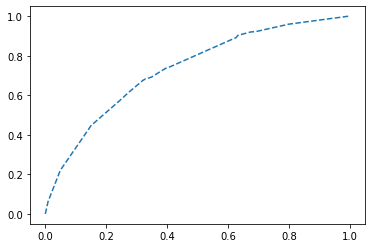

In [145]:
roc_curve(fitted, "Model1")

In [168]:
sklearn.metrics.precision_recall_fscore_support(y_test, y_pred)

(array([0.94596963, 0.20055221]),
 array([0.67039222, 0.68349016]),
 array([0.784689  , 0.31011062]),
 array([9663, 1169], dtype=int64))

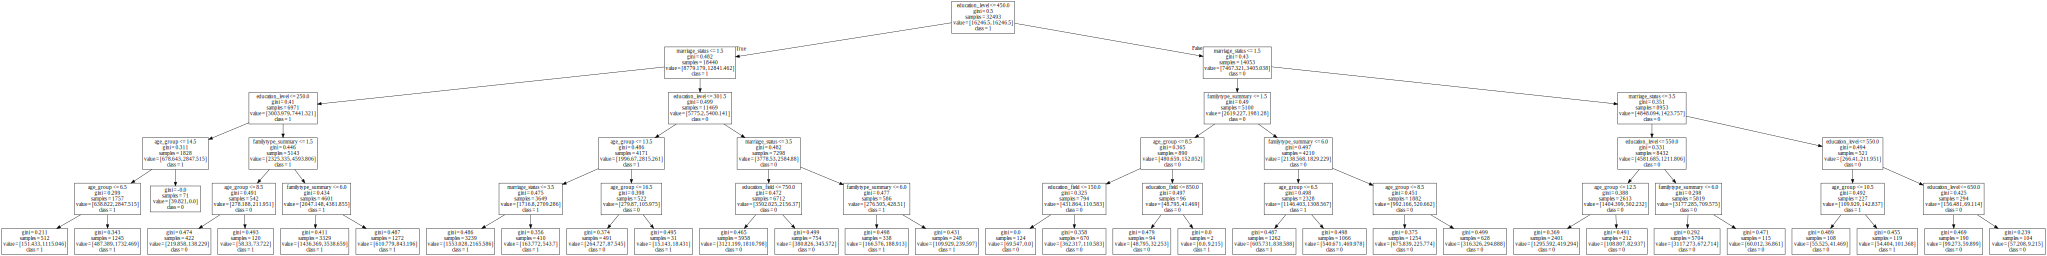

In [109]:
plot_tree(fitted)

#### Model 2: Grid Search optimal weights

In [102]:
#Do a grid search for best weights
balance=[{0:100, 1:0}, {0:90, 1:10}, {0:80, 1:20}, {0:60, 1:40}, {0:50, 1:50}, {0:40, 1:60}, {0:20, 1:80}, {0:0, 1:100}]
param_grid=dict(class_weight=balance)

#Evaluation procedure
cv=sklearn.model_selection.RepeatedStratifiedKFold(n_splits=10,n_repeats=5, random_state=1)
grid=sklearn.model_selection.GridSearchCV(estimator=model,param_grid=param_grid,cv=cv, scoring='f1')
result=grid.fit(X_train, y_train)
print(result.best_score_, result.best_params_)

#More substantial improvement needed. Explore Oversmapling.

0.23063322625996133 {'class_weight': {0: 20, 1: 80}}


#### Model 3: Random Oversampling

In [22]:
# Random Oversampling - increases training set from 32k to 57k observations. 
ros=RandomOverSampler()
X_train_ros, y_train_ros=ros.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape, X_train_ros.shape, y_train_ros.shape)
print(np.bincount(y_train_ros))

(32493, 5) (32493,) (57934, 5) (57934,)
[28967 28967]


In [165]:
#Random Oversampling Model
#min_samples_leaf=5%population
model_ros = sklearn.tree.DecisionTreeClassifier(max_depth=None, criterion='entropy', min_samples_leaf=2900)
fitted_ros = model_ros.fit(X_train_ros,y_train_ros)
y_pred_ros = fitted_ros.predict(X_test)
sklearn.metrics.confusion_matrix(y_test,y_pred_ros)


array([[6664, 2999],
       [ 448,  721]], dtype=int64)

In [162]:
sklearn.metrics.precision_recall_fscore_support(y_test, y_pred_ros)

(array([0.93700787, 0.1938172 ]),
 array([0.6896409 , 0.61676647]),
 array([0.79451565, 0.29494784]),
 array([9663, 1169], dtype=int64))

([<matplotlib.lines.Line2D at 0x1eebe1dce48>],
 'Area Under Curve:',
 0.7075219322299208)

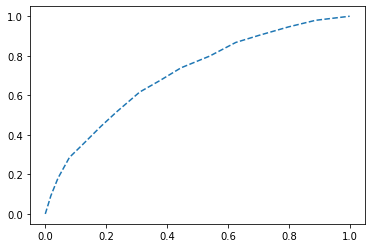

In [166]:
roc_curve(fitted_ros, "model_ros")


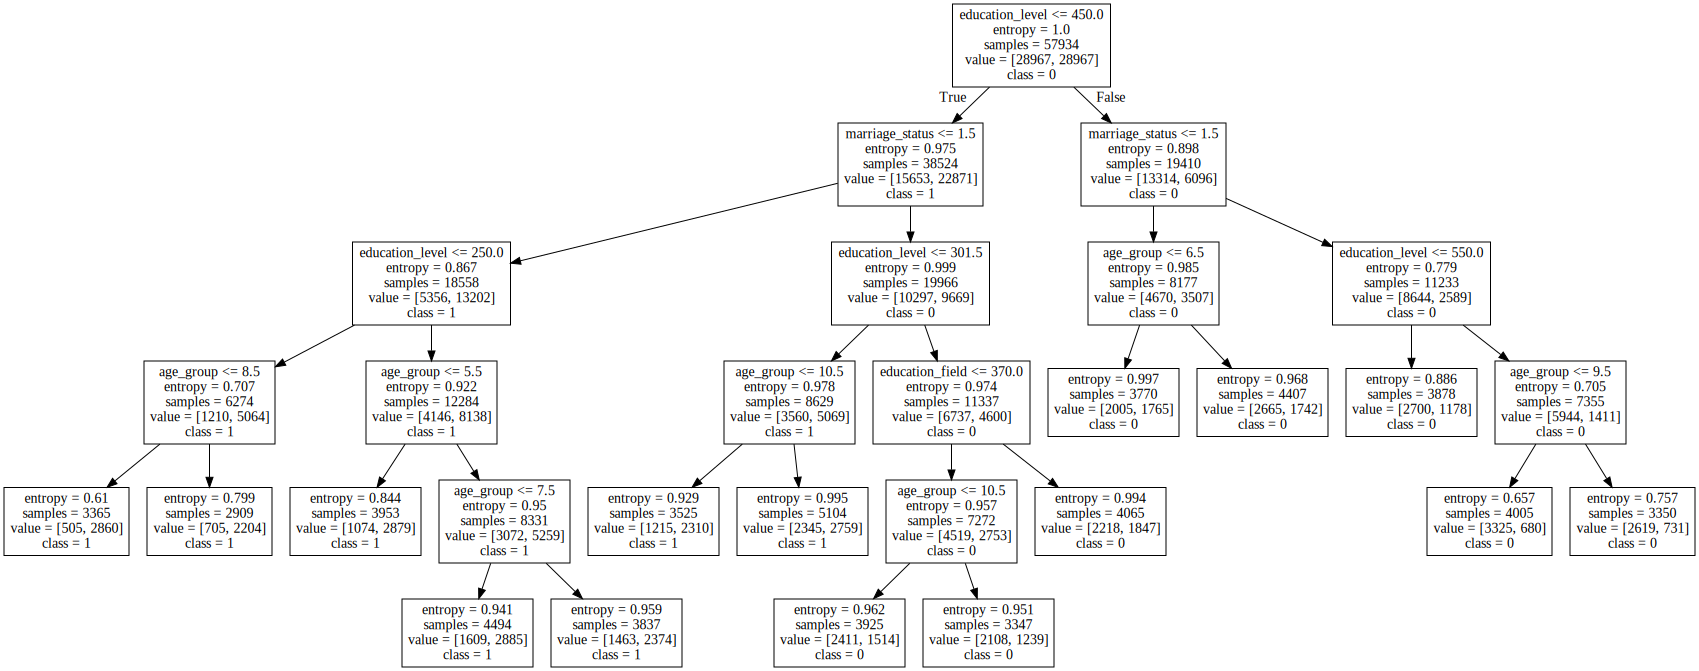

In [167]:
plot_tree(fitted_ros)